## Milton Friedman's "Optimum Quantity of Money" (1969)

#### Group 4: Christopher Perez, Ernesto Perez, Kevin Santamaria 

## Part 1: Introduction

We will be replicating Friedman's monetary framework of how changes in the quantity of money impact prices, incomes and interest rates. 

There are two parts of the model. The first part is a supply and demand model, (one can think of this side of the model as the physical economy). The second part of the model deals with changes in the money supply (or as the financial aspects of the economy).

We begin with the differential equation for the rate of change of the money supply as a function of time:

$$ \frac{dm}{dt} = M * \mu $$

Where M is the money supply and $\mu$ is the rate of change of the money supply.

This is a separable differential equation, which we solve as:

$$ \int \frac{1}{M} dm = \int \mu  dt$$

$$ ln(M) = \mu t $$

Which simplies as:

$$ M(t) = M_0e^{\mu t} $$

Here, $M_0$ is the initial condition of the money supply at time = 0

The final form of this equation is:

$$ log(M(t)) = log(M_0 e^{\mu t}) $$ 

Plugging this into the classical quantity theory of money equation, yields the following:

$$ MV = PQ $$ 

$$ log(M_0 e^{\mu t})V = PQ $$

This equation will help us solve for changes in the growth rate of the money supply.

## Part 2: Implementing Friedman's Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import math
import sympy as sym
import random
from sympy import exp

sym.init_printing(use_latex=True)

M, M_0, Y, C, S, mu = sym.symbols('M, M_0, Y, C, S, mu', positive =True)

#Initial Conditions
pop = 1000
M0 = 50000000
C = 0.9
S = 0.1

# Function that returns dm/dt
def model(M, t, mu):
    dmdt = M * mu
    return dmdt


t = np.arange(1, 13, 1)

# Solve ODEs
mu = 0.0
mt1 = odeint(model, M0, t, args=(mu,)).round(2)
mu = 0.1
mt2 = odeint(model, M0, t, args=(mu,)).round(2)
mu = -0.1
mt3 = odeint(model, M0, t, args=(mu,)).round(2)

# Total Income
Y1 = mt1 / pop
Y2 = mt2 / pop
Y3 = mt3 / pop

## This is the Income used for consumption
C1 = [int(Y * C) for Y in Y1]
C2 = [int(Y * C) for Y in Y2]
C3 = [int(Y * C) for Y in Y3]

Savings = 0.1
Savings1 = Y1 * Savings
Savings2 = Y2 * Savings
Savings3 = Y3 * Savings


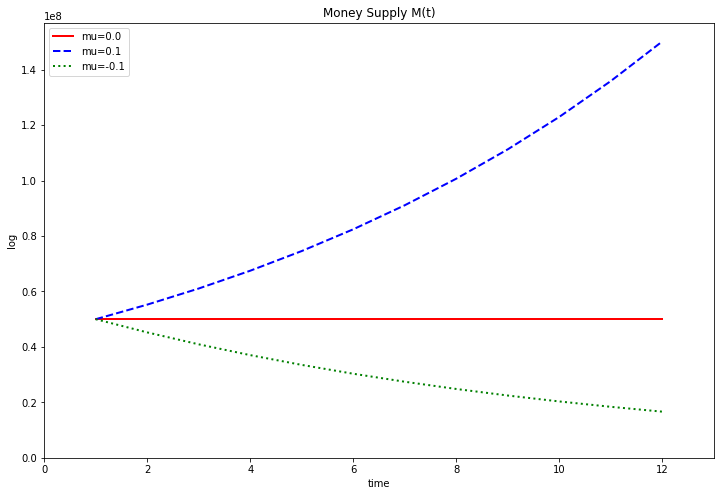

In [2]:
plt.figure(figsize=(12,8))
plt.plot(t, mt1, 'r-', linewidth=2, label = 'mu=0.0')
plt.plot(t, mt2, 'b--', linewidth=2, label = 'mu=0.1')
plt.plot(t, mt3, 'g:', linewidth=2, label = 'mu=-0.1')

plt.xlabel('time')
plt.ylabel('y(t)')

plt.ylabel("log")

plt.title('Money Supply M(t)')

plt.ylim(0)
plt.xlim(0, 13)

plt.legend()
plt.show()

Now that we have determined an aggregate level for the money supply, we can translate this to the individual income, such that

$$ log(M(t)) = Y_i * P_(pop) $$ 

And as such:

$$ Y_i = Y_c + Y_s $$ 

Where a portion of one's income ($Y_i$) is consumed ($Y_c$) or saved ($Y_s$)

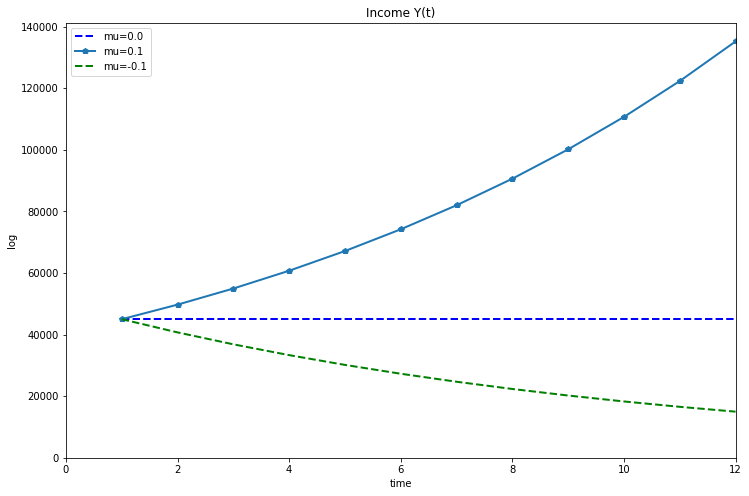

In [3]:
plt.figure(figsize=(12,8))

plt.plot(t, C1, 'b--', linewidth=2, label = 'mu=0.0')
plt.plot(t, C2, 'p-', linewidth=2, label = 'mu=0.1')
plt.plot(t, C3, 'g--', linewidth=2, label = 'mu=-0.1')

plt.xlabel('time')
plt.ylabel('y(t)')

plt.ylabel("log")

plt.ylim(0)
plt.xlim(0, 12)

plt.title('Income Y(t)')

plt.legend()
plt.show()

## Part 3: Building the Dynamic Supply and Demand Model

### Building Class: Seller 

The sellers determine their sell price preference based on their cost of goods sold (cogs), their savings, and the current money supply.

In [4]:
class Seller:

    savings = None
    cogs = None

    pref = None
    min = None

    def __init__(self, cogs, savings, M):
        self.cogs = cogs
        self.savings = savings
        self.prices(M)

    def prices(self, M):
        self.pref = random.randint(20, 60) * self.cogs   # * float(1 + ((M - M0) / M0))
        self.min = self.pref * 0.8

### Building Class: Buyer

The buyer is a little more complex. The buyers are programmed to try to aquire more goods until they have met their purchase goal.

In [5]:
class Buyer:

    purchaseGoal = 500  # Goal

    savings = 0

    pref = None
    max = None

    spend = 0
    viableSellers = list()

    def __init__(self, sellers, consumption, savings):
        self.viableSellers = sellers
        self.savings = savings
        self.spend = consumption
        self.prices()

    def prices(self):
        self.pref = random.randint(0, 40) * 0.01 * self.spend
        self.max = self.pref * 1.2

    def negotiateWith(self, seller):

        if self.spend < self.max:
            self.pref = self.spend
            self.max = self.spend

        if seller.pref <= self.pref:   # print("Easily Sold")
            self.spend -= seller.pref
            seller.savings += seller.pref - seller.cogs
            self.purchaseGoal -= 1

            return [seller.pref, self.pref, self.max, seller.pref, seller.min]

        if seller.min > self.max:       # print("Not Sold")

            return [-1, self.pref, self.max, seller.pref, seller.min]

        # print("Sold after Negotiating")
        self.spend -= (seller.pref + self.pref) / 2
        seller.savings += ((seller.pref + self.pref) / 2) - seller.cogs
        self.purchaseGoal -= 1
        return [
            (seller.pref + self.pref) / 2,
            self.pref,
            self.max,
            seller.pref,
            seller.min,
        ]

    def determineFuture(self, seller):
        if self.purchaseGoal == 0:
            self.viableSellers.clear()
        elif self.spend < seller.min or self.max < seller.min:
            self.viableSellers.remove(seller)


### I. Defining the Model

Here we create the buyers and sellers, assign them a consumption and savings amount, and pair them up so that they dynamically determine their transaction price.

In [6]:
def Model(pop, M, consumption, savings, buyerGoal):

    NumSellers = int(pop * 0.04)
    NumBuyers = int(pop * 0.96)

    consumptionsUnadjusted = [random.gauss(40000, 10000) for x in range(NumBuyers)]
    consumptions = [
        (i / sum(consumptionsUnadjusted)) * consumption for i in consumptionsUnadjusted
    ]

    savingsUnadjusted = [random.gauss(6000, 2000) for x in range(pop)]
    savings = [(i / sum(savingsUnadjusted)) * savings for i in savingsUnadjusted]

    allBuyers = []
    allSellers = []

    for i in range(NumSellers):
        allSellers.append(
            Seller((sum(consumptions) / len(consumptions)) * 0.02, savings[i], int(M))
        )

    for i in range(NumBuyers):
        allBuyers.append(Buyer(allSellers[:], consumptions[i], savings[i + NumSellers]))

    Buyers = allBuyers[:]
    Sellers = allSellers[:]

    TransactionInfo = []


    while len(Buyers) != 0:
        index = 0
        for buyer in Buyers:

            seller = random.choice(buyer.viableSellers)

            TransactionInfo.append(Buyers[index].negotiateWith(seller))

            buyer.determineFuture(seller)

            if buyer.spend <= 0:
                Buyers.remove(buyer)
            elif not buyer.viableSellers:
                Buyers.remove(buyer)

            index += 1

    Transactions = [round(x[0], 2) for x in TransactionInfo if x[0] != -1]

    totalSavings = 0

    for x in allBuyers:
        totalSavings += x.savings

    for x in allSellers:
        totalSavings += x.savings

    def interestRate():

        stillWant = 0

        for x in allBuyers:
            if x.purchaseGoal != 0:
                stillWant += x.purchaseGoal

        moneyDemand = int(M) + (stillWant) * (
            sum(Transactions) / (len(Transactions) if len(Transactions) > 0 else 1)
        )

        r = sym.Symbol("r")
        y = sym.solve(
            sym.Eq(moneyDemand, int(totalSavings) + (0.1 / 500) * M0 * (buyerGoal / r)),
            r,
        )

        if len(y) == 0:
            y.append(0)

        return [y[0], moneyDemand]

    return [Transactions, TransactionInfo, interestRate(), totalSavings]

### II. Running the Model

In [7]:
first = []

for i in range(len(C1)):
    save = Model(pop, mt1[i], C1[i], Savings1[i], 500)
    first.append(
        [
            (sum(save[0]) / (len(save[0]) if len(save[0]) > 0 else 1)),
            (len(save[0])),
            save[2][0],
            mt1[i],
            save[3],
            save[2][1],
            save[0],
            save[1]
        ]
    )   

normalTransactions = 0
index = 0
for period in first:
    normalTransactions += first[index][1]
    index += 1

supplyMinA = [x[4] for x in save[1]]
supplyPrefA = [x[3] for x in save[1]]
buyerMaxA = [x[2] for x in save[1]]
buyerPrefA = [x[1] for x in save[1]]



second = []

for i in range(len(C2)):
    save = Model(pop, mt2[i], C2[i], Savings2[i], 500)
    second.append(
        [
            (sum(save[0]) / (len(save[0]) if len(save[0]) > 0 else 1)),
            (len(save[0])),
            save[2][0],
            mt1[i],
            save[3],
            save[2][1],
            save[0],
            save[1]
        ]
    )

inflationTransactions = 0
index = 0
for period in second:
    inflationTransactions += second[index][1]
    index += 1
    
supplyMinB = [x[4] for x in save[1]]
supplyPrefB = [x[3] for x in save[1]]
buyerMaxB = [x[2] for x in save[1]]
buyerPrefB = [x[1] for x in save[1]]



third = []

for i in range(len(C3)):
    save = Model(pop, mt3[i], C3[i], Savings3[i], 500)
    third.append(
        [
            (sum(save[0]) / (len(save[0]) if len(save[0]) > 0 else 1)),
            (len(save[0])),
            save[2][0],
            mt1[i],
            save[3],
            save[2][1],
            save[0],
            save[1]
        ]
    )
    

deflationTransactions = 0
index = 0
for period in third:
    deflationTransactions += third[index][1]
    index += 1
    
supplyMinC = [x[4] for x in save[1]]
supplyPrefC = [x[3] for x in save[1]]
buyerMaxC = [x[2] for x in save[1]]
buyerPrefC = [x[1] for x in save[1]]

## III. Graphs

### Graph I: Supply and Demand

#### Graph I: Year 12 with a Money Supply Growth Rate of 0% 

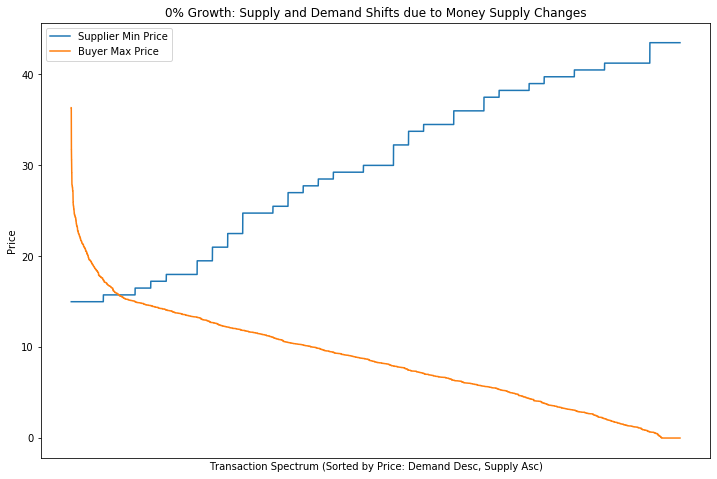

In [8]:
supplyMinA.sort()
buyerMaxA.sort(reverse=True)

plt.figure(figsize=(12,8))
plt.plot(
    [x for x in range(1, len(supplyMinA) + 1)],
    supplyMinA,
    label="Supplier Min Price",
)
plt.plot(
    [x for x in range(1, len(buyerMaxA) + 1)],
    buyerMaxA,
    label="Buyer Max Price",
)
plt.xlabel("Transaction Spectrum (Sorted by Price: Demand Desc, Supply Asc)")
plt.ylabel("Price")
plt.legend()
plt.title("0% Growth: Supply and Demand Shifts due to Money Supply Changes")
plt.xticks([])
#plt.annotate("o", (5, second[0]))
plt.show()

#### Graph I: Year 12 with a Money Supply Growth Rate of 10%

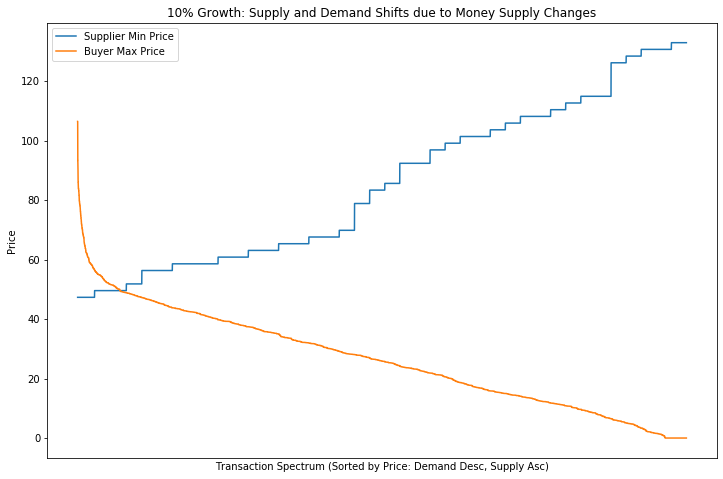

In [9]:
supplyMinB.sort()
buyerMaxB.sort(reverse=True)

plt.figure(figsize=(12,8))
plt.plot(
    [x for x in range(1, len(supplyMinB) + 1)],
    supplyMinB,
    label="Supplier Min Price",
)
plt.plot(
    [x for x in range(1, len(buyerMaxB) + 1)],
    buyerMaxB,
    label="Buyer Max Price",
)
plt.xlabel("Transaction Spectrum (Sorted by Price: Demand Desc, Supply Asc)")
plt.ylabel("Price")
plt.legend()
plt.title("10% Growth: Supply and Demand Shifts due to Money Supply Changes")
plt.xticks([])
plt.show()

#### Graph I: Year 12 with a Money Supply Growth Rate of -10%

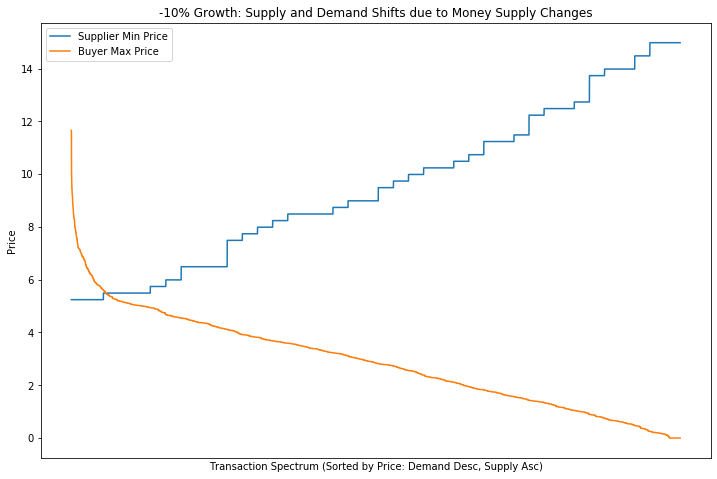

In [10]:
supplyMinC.sort()
buyerMaxC.sort(reverse=True)

plt.figure(figsize=(12,8))
plt.plot(
    [x for x in range(1, len(supplyMinC) + 1)],
    supplyMinC,
    label="Supplier Min Price",
)
plt.plot(
    [x for x in range(1, len(buyerMaxC) + 1)],
    buyerMaxC,
    label="Buyer Max Price",
)
plt.xlabel("Transaction Spectrum (Sorted by Price: Demand Desc, Supply Asc)")
plt.ylabel("Price")
plt.legend()
plt.title("-10% Growth: Supply and Demand Shifts due to Money Supply Changes")
plt.xticks([])
plt.show()

### Graph II: Equilibrium Prices with Changes to the Quantity of Money 

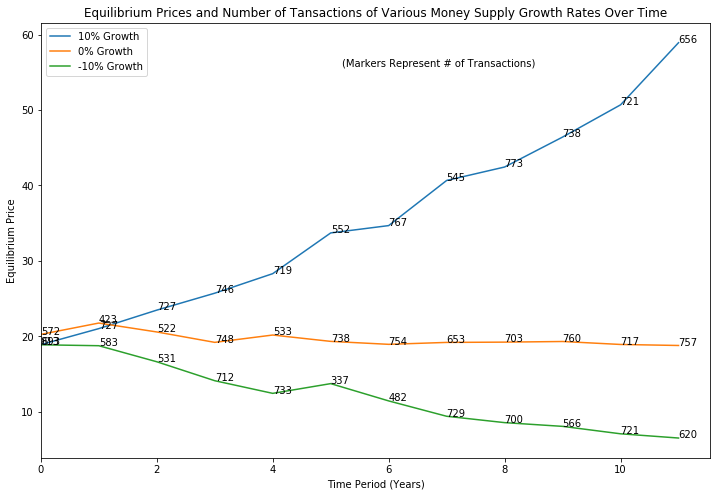

In [11]:
time = [x for x in range(0, len(first))]

plt.figure(figsize=(12,8))
plt.plot(time, [x[0] for x in second], label="10% Growth")
plt.plot(time, [x[0] for x in first], label="0% Growth")
plt.plot(time, [x[0] for x in third], label="-10% Growth")

for x in range(len(time)):
    plt.annotate(first[x][1], (time[x], first[x][0]))
    plt.annotate(second[x][1], (time[x], second[x][0]))
    plt.annotate(third[x][1], (time[x], third[x][0]))

    
plt.xlim(0)
plt.xlabel("Time Period (Years)")
plt.ylabel("Equilibrium Price")
plt.legend()
plt.annotate(
    "(Markers Represent # of Transactions)", xy=(0.45, 0.9), xycoords="axes fraction"
)
plt.title(
    "Equilibrium Prices and Number of Tansactions of Various Money Supply Growth Rates Over Time"
)
plt.show()

### Graph III: Number of Transactions as Money Supply Changes

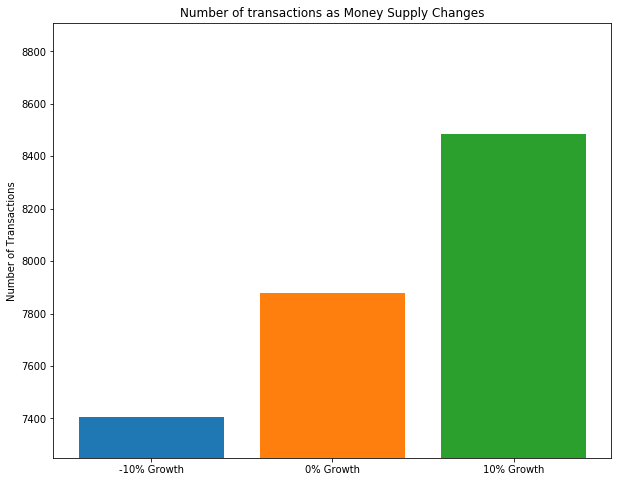

In [18]:
plt.figure(figsize=(10,8))
plt.bar(
    "-10% Growth",
    deflationTransactions,

)
plt.bar(
    "0% Growth",
    normalTransactions,
)
plt.bar(
    "10% Growth",
    inflationTransactions,

)
plt.ylabel("Number of Transactions")
plt.ylim(7250)
plt.title("Number of transactions as Money Supply Changes")
plt.show()


### Graph IV: Velocity of Money  as Money Supply Changes

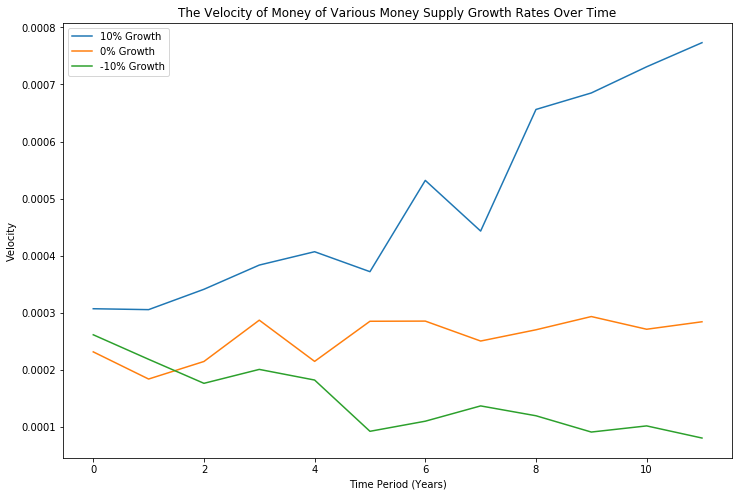

In [13]:
plt.figure(figsize=(12,8)),
plt.plot(time, [(x[0] * x[1]) / x[3] for x in second], label="10% Growth")
plt.plot(time, [(x[0] * x[1]) / x[3] for x in first], label="0% Growth")
plt.plot(time, [(x[0] * x[1]) / x[3] for x in third], label="-10% Growth")
plt.xlabel("Time Period (Years)")
plt.ylabel("Velocity")
plt.legend()
plt.title("The Velocity of Money of Various Money Supply Growth Rates Over Time")
plt.show()

## Multiple Methods for Determining Interest Rates

### Graph V:

$$ Interest Rate = \frac {TotalSavings} {Money Supply} $$

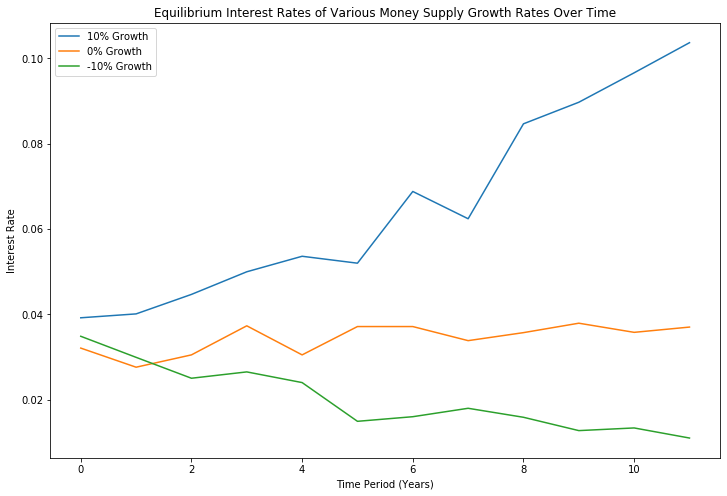

In [14]:
plt.figure(figsize=(12,8))
plt.plot(time, [100*x[4] / x[3] for x in second], label="10% Growth")
plt.plot(time, [100*x[4] / x[3] for x in first], label="0% Growth")
plt.plot(time, [100*x[4] / x[3] for x in third], label="-10% Growth")
plt.xlabel("Time Period (Years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.title("Equilibrium Interest Rates of Various Money Supply Growth Rates Over Time")
plt.show()

### Graph VI:

$$ Interest Rate = \frac {Money Demand} {Total Savings} $$

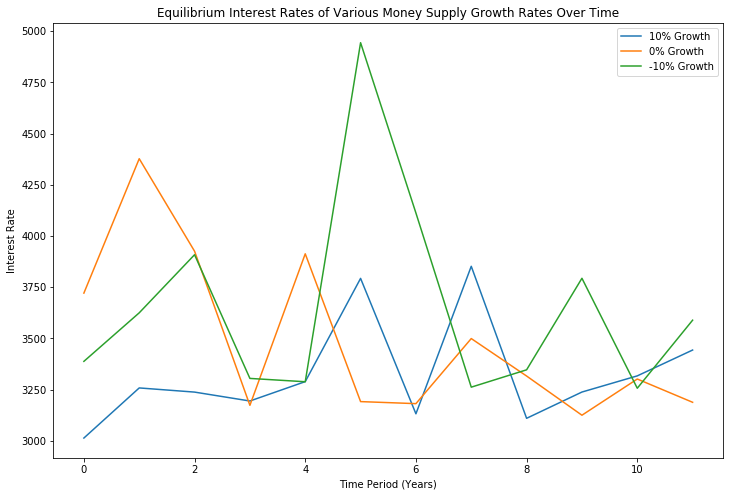

In [15]:
plt.figure(figsize=(12,8))
plt.plot(time, [x[5] / x[4] for x in second], label="10% Growth")
plt.plot(time, [x[5] / x[4] for x in first], label="0% Growth")
plt.plot(time, [x[5] / x[4] for x in third], label="-10% Growth")
plt.xlabel("Time Period (Years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.title("Equilibrium Interest Rates of Various Money Supply Growth Rates Over Time")
plt.show()

### Graph VII:  

$$ MoneyDemand = TotalSavings + \frac{0.1M_0}{500}\times\frac{BuyerGoal}{r} $$

Solve for r

$$ r = \frac{0.1(M_0BuyerGoal)}{500(MoneyDemand-TotalSavings)} $$

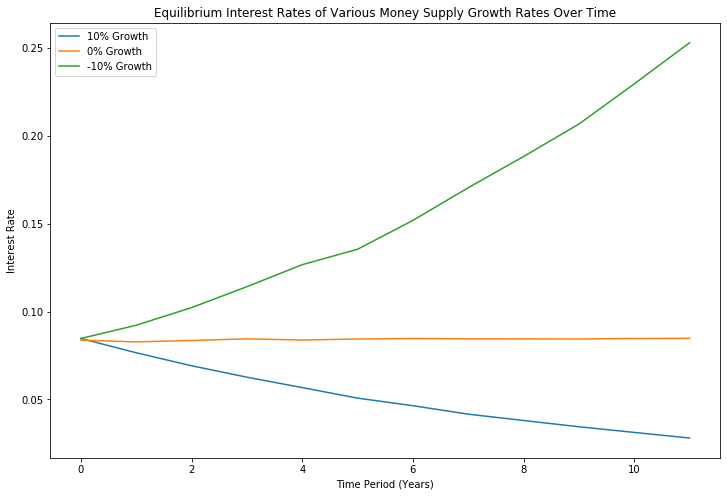

In [16]:
plt.figure(figsize=(12,8))
plt.plot(time, [x[2] for x in second], label="10% Growth")
plt.plot(time, [x[2] for x in first], label="0% Growth")
plt.plot(time, [x[2] for x in third], label="-10% Growth")
plt.xlabel("Time Period (Years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.title("Equilibrium Interest Rates of Various Money Supply Growth Rates Over Time")
plt.show()

## Part 4: Policy Implications of the Model

Why haven't prices increased despite trillions of dollars in stimulus caused by the Coranavirus Crisis?

• Our model reflects how changes in the money supply affected general prices in the macroeconomy.

• Our central focus of Friedman's model is the money supply. As such, Friedman holds all other aspects of the model constant (which are money velocity and real production.)

• Why hasn’t the recent increase in the money supply caused inflation? This is because, if real production keeps up with the money supply or the velocity decreases, we see an equal amount of prices reflected in the real economy, so there is no “inflation” per say.

## Part 5: Further Research

This model can be further expanded to describe a more complex economy.

For example, interest rates can be determined in a dynamic supply and demand model as well, however, more complexity would be needed, as buyers would acquire bonds and sellers would acquire interest rate payments. Bonds would have to expire after a period of time and interest rates would vary depending on how much slack there is in the economy.

In addition, the model can be adjusted to explain periods of disequilibrium (depressions and hyperinflation) by introducing debt instruments for depressions, and adding more chaotic growth rates for the money supply (i.e., rather than growing by a defined mu, the growth rate of the money supply would be determined by a random range).

The model can also be expanded to consider the foreign demand for an economy's currency and the effect of being a reserve currency.

The model can also be expanded to show how the prices of items that buyers usually borrow for move in relation to the prices of items that are usually bought outright, contingent on the model controling the money supply through lending.

Finally, the income of buyers can be modeled more realistically by introducing real world data and creating a distribution accordingly.

Overall, we believe this model introduces the mechanics of monetary behavior in the economy and can shed light on the dynamic nature of the economy.